# Introducing Markov Chain Monte Carlo

One way to look at Markov Chain Monte Carlo methods is that they provide techniques to explore possible solutions to a problem. But to make more sense of this we first need to introduce some concepts.

## The likelihood

When you got some data and a model you usually want to compare the two. How do you do that?

The first thing that comes to mind is to say that you want to find the model that is the _closest_ to the data. But that raises several questions: firstly, what do you mean by "close"? Say that you have a set of ${x_i, y_i}$ values. Then the simplest approach is to calculate the model for each $x_i$ and take as a distance $d_1=\left|x_i - M(x_i)\right|$ or $d_2 = \left(x_i - M(x_i)\right)^2$. It is most common to use $d_2$ because it lends itself more to differentiation so I will use that in the following &mdash; it is also the natural choice if uncertainties are Gaussian. The second issue is that a Model might be close for some $x_i$ but not for others, so how do you compare different models? 

A different way to think about this problem, which leads us to $d_2$ as well, is to think about one data point at the time. Now say we have a model $M_{\boldsymbol\theta}$, where $\boldsymbol{\theta}$ is some set of labels specifying the model. I have chosen $\boldsymbol\theta$ because this is often used in the literature but it could be anything, like $\mathbf{k}$, instead. Now I want to ask: what is the likelihood of the observation $y_i$, given a model $M_{\boldsymbol\theta}$ and a data point $x_i$. 

We write the likelihood of the $y_i$ as $P(y_i | M_{\boldsymbol\theta}, x_i)$ and read it as the likelihood of $y_i$ given the model, $M$ with parameter(s) $\boldsymbol\theta$ and measurement $x_i$. Now to answer the question of what this is, we need to have a model for how our observations are created. We always need this actually, but only in this particular formulation do we need to state this explicitly. The simplest assumption usually made is that
$$
y_i = M_{\boldsymbol\theta}(x_i) + \epsilon_i\,,
$$
where $M_{\boldsymbol\theta}(x)$ is some function and $\epsilon_i$ refers to the noise that is added to a real observation. If there was no noise in our system then $\epsilon_i$ would disappear. 

What is $\epsilon$? It is a random number, drawn from some *distribution*. The most common, and what we use here, is to assume that we have what is called Gaussian noise. In this case the distribution is a Gaussian, or normal, distribution. We write this typically as
$$
\epsilon_i \sim {\cal N}(0, \sigma_i^2)\,,
$$
where $N$ stands for the normal distribution, 0 means that the distribution has a mean of zero and $\sigma_i^2$ is the variance of the distribution. The mathematical expression for the normal distribution is:
$$
{\cal N}(\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} e^{-(x-\mu)^2/2\sigma^2}\,,
$$
which you probably have seen before, but let me show a few example plots:

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
xx = np.linspace(-7, 7, 500)
# Note that the convention in scipy.stats is that the second argument is the
# standard deviation and _not_ the variance as is common in the literature. Thus
# 0.5 is the standard deviation with 0.25 being the variance.
y_narrow = st.norm(0, 0.5)
y_unity = st.norm(0, 1.0)
y_wide = st.norm(0, 1.5)

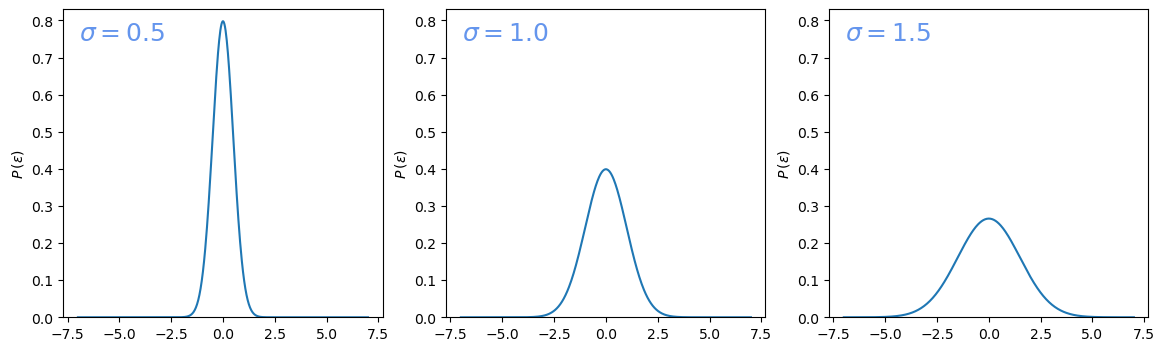

In [3]:
def label_one(ax, sigma):
    """
    Simple labeling of plot
    """

    tmp = "{0:.1f}".format(sigma)
    ax.text(
        0.05,
        0.9,
        r"$\sigma = " + tmp + "$",
        transform=ax.transAxes,
        fontsize=18,
        color="CornFlowerBlue",
    )


fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(14, 4)

# The narrower distribution - note I can get the
# standard deviation back by using the std function
axes[0].plot(xx, y_narrow.pdf(xx))
label_one(axes[0], y_narrow.std())

# The middle
axes[1].plot(xx, y_unity.pdf(xx))
label_one(axes[1], y_unity.std())

# The wide distribution
axes[2].plot(xx, y_wide.pdf(xx))
label_one(axes[2], y_wide.std())

# Fix the y-limit
for a in axes:
    a.set_ylim(0, 0.83)
    a.set_ylabel(r"$P\,(\epsilon)$")

plt.show()

As you can see, changing the variance changes the width significantly. You should think of $\epsilon$ as taking values from this distribution with the frequency/likelihood given by the height of the curve. 

Ok, armed with this, what then is the likelihood? Well now we can predict the value of $y_i$. This is 

$$
 y_{\mathrm{pred}} = M_{\boldsymbol\theta}(x_i)
$$

But from the equation earlier we see that $y_i - M_{\boldsymbol\theta}(x_i)$ is a random number distributed following the normal distribution, so we must have that 

$$
L_i = P\left(y_i | x_i, M_{\boldsymbol\theta}(x_i)\right) = \frac{1}{\sigma_i\sqrt{2\pi}} e^{-(y_i-M_{\boldsymbol\theta}(x_i))^2/2\sigma_i^2},
$$
which we refer to as a the likelihood (hence the $L_i$) and where $\sigma_i$ is the measurement uncertainty on observation $i$. 

It is customary (and a good idea) to take logs of this and the log likelihood is:
$$
\ln L_i = -\frac{1}{2} \left(\frac{y_i-M_{\boldsymbol\theta}(x_i)}{\sigma_i}\right)^2 - \ln(\sigma_i\sqrt{2\pi})
$$

To get the likelihood of many observations, we need to multiply the individual likelihoods, so calculate $L=\prod_i L_i$, or in log likelihood, sum over all likelihoods. If we also ignore the terms $\ln(\sigma_i\sqrt{2\pi})$, which are just constants, we have
$$
\ln L = -\frac{1}{2} \sum_i \left(\frac{y_i-M_{\boldsymbol\theta}(x_i)}{\sigma_i}\right)^2 
$$
which you should recognise as $\chi^2/2$. 




## Fitting data to a straight line

If our data follow a straight line, we should have
$$
y_i = a + b x_i + \epsilon_i,
$$
which we can put into the equation above, to get
$$
\ln L = -\frac{1}{2} \sum_i \left(\frac{y_i-a - b x_i}{\sigma_i}\right)^2 
$$
and which we can now implement in Python.



In [4]:
def lnL(theta, x, y, yerr):
    """
    The log likelihood of our simplistic Linear Regression.
    """
    a, b = theta
    model = b * x + a
    inv_sigma2 = 1.0 / (yerr**2)

    return -0.5 * (np.sum((y - model) ** 2 * inv_sigma2))

We can then define some data and try to fit this:

In [5]:
x = np.array([-1.97, 1.90, -1.36, -0.41, 2.64])
y_obs = np.array([-3.26071857, 4.28121648, 1.01564296, 0.56407676, 6.00958494])
dy = 1.2
a_true = 1.4
b_true = 1.3
# The y-obs were created adopting an equation y = 1.4 + 1.3 x
#
# y = 1.3*x + 1.4
#
#   To make the calculation reproducible I set the random seed:
# np.random.seed(100)
#
# y_obs = y + np.random.normal(0, dy, size=len(x))
#

In [6]:
# Let me first assume that I know the intercept (1.4) and then calculate lnL over a range of slopes

bs = np.linspace(0, 3.5, 100)
log_likelihood = np.zeros_like(bs)
for i, b in enumerate(bs):
    theta = (1.4, b)
    log_likelihood[i] = lnL(theta, x, y_obs, dy)

The plot below then plots this log likelihood on the left, and the likelihood on the right, indicating the correct b value by the dashed red line. The data fitted is shown in the last panel.

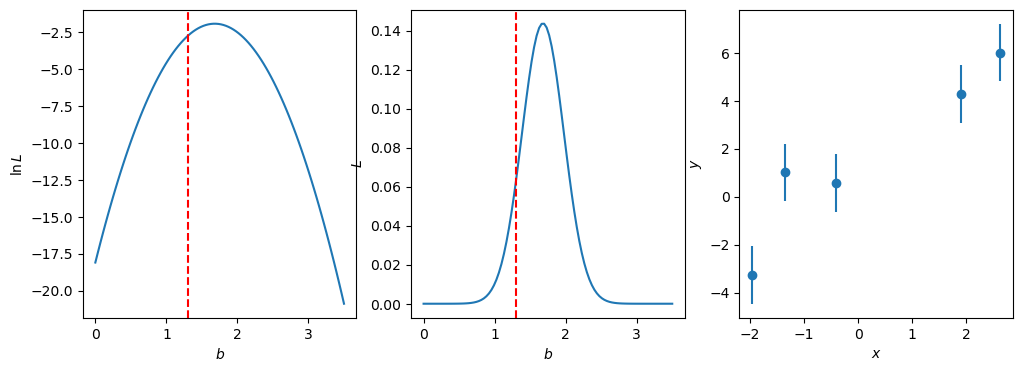

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(12, 4)
axes[0].plot(bs, log_likelihood)
axes[0].axvline(1.3, ls="dashed", color="red")
axes[0].set_xlabel(r"$b$")
axes[0].set_ylabel(r"$\ln L$")

axes[1].plot(bs, np.exp(log_likelihood))
axes[1].axvline(1.3, ls="dashed", color="red")
axes[1].set_xlabel(r"$b$")
axes[1].set_ylabel(r"$L$")

axes[2].scatter(x, y_obs)
axes[2].errorbar(x, y_obs, yerr=dy, linestyle="none")
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$y$")

plt.show()

You can see that the likelihood does not peak at the correct value, but it does not exclude it either &mdash; there is significant likelihood also at the correct slope. 

## Moving on to a Bayesian analysis

In a Bayesian analysis we are not only interested in the likelihood of the data given the model, we are interested in the likelihood of the model given the data. To calculate this we use Bayes' rule:

$$
P(\mathrm{Model}|\mathrm{data}) = \frac{P(\mathrm{data}|\mathrm{model})\, P(\mathrm{model})}{P({\mathrm{data}})}
$$

We will ignore the denominator $P(\mathrm{data})$, because this is independent of the model so will not influence our fitting. That leaves only $P(\mathrm{model})$ as our new ingredient. This is called the _prior_ and encodes our belief/trust in our model (any information we may already have about the parameters of the model). In the calculation just above, for instance, I assumed that I knew $a$ perfectly &mdash; that is a prior assumption. So we need to specify the priors when we use this approach. 

Given a prior, and a likelihood we can then calculate a Markov Chain Monte Carlo (MCMC) fit to our data. But first we need to define the prior. Again I will use logarithms and so then when $P=0$ I need to return $-\infty$.

In [8]:
def lnprior(theta):
    """
    Define a prior that allows intercepts between -5 and 5 and is zero outside and
    slopes between -10 and 10 and is zero outside. Between the limits it is flat.
    """
    a, b = theta
    if -5.0 < a < 5.0 and -10.0 < b < 10.0:
        return 0.0
    return -np.inf


def lnprob(theta, x, y, yerr):
    """
    The likelihood to include in the MCMC.
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y, yerr)

The `lnprob` function above combines the likelihood and the prior to give the right hand side in Bayes' rule and this is what we need for our MCMC running.

## Running MCMC

We will use a Python package called `emcee` to do our MCMC calculations. The `emcee` package is written by Dan Foreman-Mackey, an astronomer, and is [freely available](https://emcee.readthedocs.io/en/stable/). It is also a quite friendly MCMC package and easy to use for the beginner. The description below is close to that on the `emcee` website but is somewhat simplified

To use `emcee` you need to import it.

In [9]:
import emcee

Then you need to define a function that returns the log likelihood of your model. We did this with `lnprob` above, and we need to create some starting positions. A common way to do this is to take the results of a $\chi^2$ fit as the starting points, but a decent guess is all that is needed and I will use that here. 

But before we get this going we need to set up the problem. We need to tell `emcee` what the dimensionality of the problem is (the number of free parameters) and the number of `walkers' we want. Walkers explore the parameter space by making random walks &mdash; 100 is a good starting number. So let us do this:

In [10]:
# Set up the properties of the problem.
ndim, nwalkers = 2, 100

# My guess at a solution - the plot above shows a slope a bit above 1 and at x=0 we have y around 1.
a_guess = 1.0
b_guess = 1.2
theta_guess = np.array([a_guess, b_guess])

But actually, we need a bunch of random starting positions - if they are all the same each walker will find the same solution &mdash; not what we want! So we do this this way:

In [11]:
pos = [theta_guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

That is actually enough to run `emcee` &mdash; we do this first by setting up a sampler (a random walk machine), and then by actually running this &mdash; here I do the run 500 times.

In [12]:
# Create the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_obs, dy))

In [13]:
tmp = sampler.run_mcmc(pos, 500)

## Analysing the output of emcee

The next step is to look at the sampler. The first steps are what is called a burn-in. This is a phase where the random walkers feel their way through parameters space and we want to throw this phase away. To figure out when to do that, we plot the track of each sampler. This is stored inside the sampler object and is called the _chain_. Let us see what this looks like:

In [14]:
sampler.chain.shape

(100, 500, 2)

so there are 100 walkers, 2 dimensions (intercept and slope) and we have run it 500 times. Let us plot this:

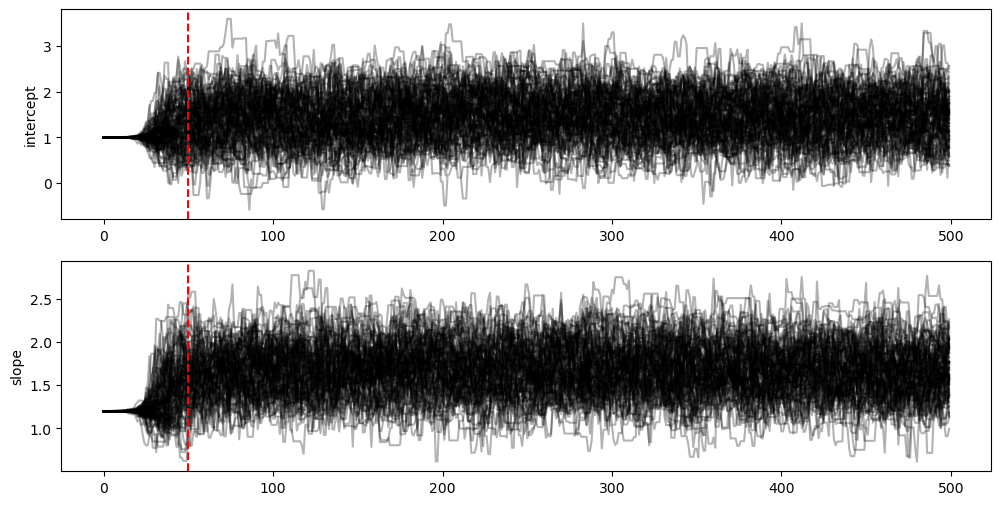

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(12, 6)
axes[0].plot(sampler.chain[:, :, 0].transpose(), color="black", alpha=0.3)
axes[0].set_ylabel("intercept")
axes[0].axvline(50, ls="dashed", color="red")
axes[1].plot(sampler.chain[:, :, 1].transpose(), color="black", alpha=0.3)
axes[1].set_ylabel("slope")
axes[1].axvline(50, ls="dashed", color="red")

plt.show()

As you can see, there is a sequence at the start where the values are close to the starting point but then they spread out and explore all of parameter space. We want to discard these. I put a line above at 50 because after that it seems more or less relaxed. From now on we do not care about the individual walkers anymore so we can now discard these and compress it all into a 2-dimensional array:

In [16]:
samples = sampler.chain[:, 50:, :].reshape((-1, 2))
samples.shape

(45000, 2)

Finally we now need to look at our data a bit more practically. The traditional way to do this in the MCMC world is to use a corner plot:

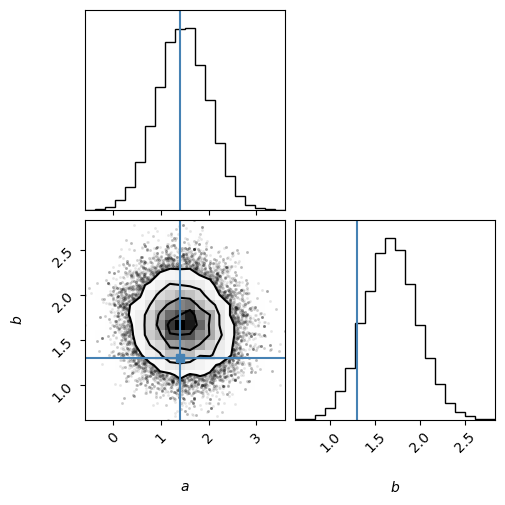

In [17]:
import corner

fig = corner.corner(samples, labels=["$a$", "$b$"], truths=[a_true, b_true])

How should you read this? Well, what it shows in the contour plot is the 2-dimensional likelihood of the data on the axes &mdash; so $a$ and $b$. On top of the contours true value of $(a,b)$ is shown (blue square). On the top and right are marginalised histograms &mdash; these are effectively the result of summing the 2D histogram vertically and horizontally respectively. These are often what we want to have.

## Marginalisation - the way to get rid of nuisances

When you run MCMC in general you will have more than one model parameter. Often you have many, in fact we often have cases where we might have thousands. A 1000-dimensional likelihood is not very easy to work with and in almost all cases we are only interested in a few variables. So what do we do? 

We marginalise. That is, we sum/integrate over all variables we do not care about. In our case it would look like:

$$
P(a|\mathrm{data}) = \int P\left(a, b | \mathrm{data}\right) db,
$$

if we only wanted the likelihood of the intercept for instance. This is actually precisely what the walker provides &mdash; or what we have in `samples`:

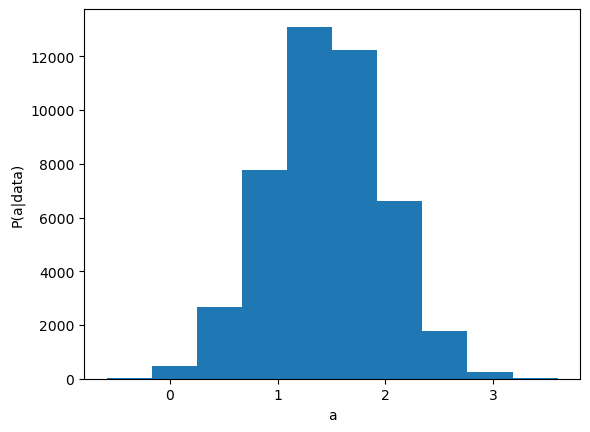

In [19]:
h = plt.hist(samples[:, 0])
plt.xlabel("a")
plt.ylabel("P(a|data)")
plt.show()

The most common way to summarise this result is then to calculate the median of the distribution as the best value, and give the 16th and 84th percentiles as the uncertainty range. For a Gaussian distribution this would correspond to $\pm 1 \sigma$. We can calculate these values easily using `scipy.stats.scoreatpercentile`:

In [24]:
summary_a = st.scoreatpercentile(samples[:, 0], [16, 50, 84])
print(summary_a)

[0.9170006  1.45741635 1.993012  ]


In [22]:
summary_b = st.scoreatpercentile(samples[:, 1], [16, 50, 84])
print(summary_b)

[1.38341114 1.67622096 1.9732227 ]


So in more common notation we have that 

$$ a = 1.46^{+0.54}_{-0.54} $$

and 

$$ b = 1.68^{+0.30}_{-0.29}$$

In fact we could get this automatically from the corner plot:

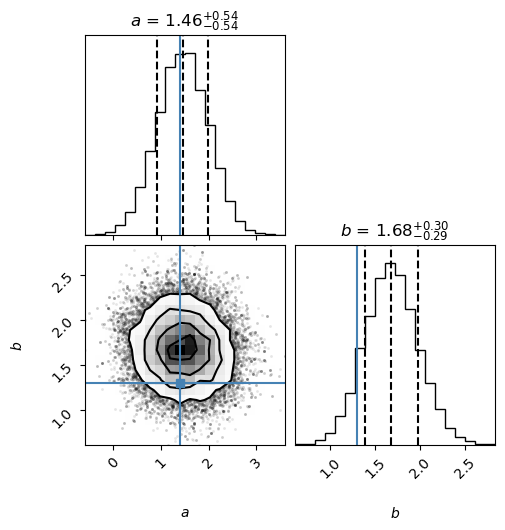

In [25]:
fig = corner.corner(
    samples,
    labels=["$a$", "$b$"],
    truths=[a_true, b_true],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
)

But doing it manually you have a lot more control of course. 